In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML


## For a data studio project, I looked at Boston Police Department disciplinary records from 2011-2021. It's well known the Department has an accountability problem, and I wanted to create visualizations to examine this from a new angle. I wanted to know, are officers who are consistently refferred to internal affairs and found guilty less likely to receive a promotion over the course of their career? But this is hard to work out with visuals! Most of the work was doing calculations so I knew my conclusions were solid and then making charts that had more aesthetic than informative value.



## I found that the answer was not really. The proportions of officers getting one, two, three, or even more promotions was essentially the same for groups with any number of allegations and any number of guilty verdicts. At least, it ~looked~ like that was the case. But maybe the one or two percentage point differences were meaningful. To investigate, I'll use an ANOVA test because there are several distributions that need to be investigated (one for each possible number of allegations/guilty findings). [Asterisk, the numbers of these things aren't strictly continuous in the sense that they obviously can only be integers. So this might all be a grave statistical sin.]

## The null hypothesis here is that number of allegations and the number of guilty findings against an officer are unrelated to the number of promotions they've received. An alternative hypothesis would be that the mean number of promotions is different for officers with different number of allegations/guilty findings against them.

In [3]:
df = pd.read_csv('bpd.csv')
df.head()

,name,department_name,title,regular,retro,other,overtime,injured,detail,quinn,total_earnings,zip,year,allegations,sustained,promotion
0,abascianojoseph,Boston Police Department,Police Officer,$68181.24,$0.00,$3763.50,$14177.65,$0.00,$4867.00,$0.00,90989.39,02132-3802,2011,2,0,0
1,abascianojoseph,Boston Police Department,Police Officer,$69432.97,$0.00,$800.00,$16767.14,$0.00,$1767.00,$0.00,88767.11,02132-3802,2012,0,0,0
2,abascianojoseph,Boston Police Department,Police Officer,$66673.45,$0.00,$800.00,$20318.50,$3163.30,$890.00,$0.00,91845.25,02132-3802,2013,1,0,0
3,abascianojoseph,Boston Police Department,Police Officer,$19469.90,$10200.36,$1491.24,$2565.64,$60753.78,$2553.00,$825.04,97858.96,02132,2014,0,0,0
4,abascianojoseph,Boston Police Department,Police Officer,$-886.20,$0.00,$8088.35,$544.83,$81996.78,$0.00,$20667.80,110411.56,02132,2015,0,0,0


In [4]:
# Putting the data we care about into a separate dataframe

names = df.name.unique()
allegations = df.groupby('name').allegations.sum().values
promotions = df.groupby('name').promotion.sum().values
sustained = df.groupby('name').sustained.sum().values

summary_df = pd.DataFrame({'name': names, 'allegations': allegations, 'promotions': promotions, 'sustained': sustained})
summary_df.head()

,name,allegations,promotions,sustained
0,abascianojoseph,4,0,0
1,abdul-azizramadani,2,0,2
2,abreucesar,4,0,0
3,acerichardk,15,1,7
4,acevedorafaelw,0,0,0


In [12]:
%%R -i summary_df

summary(aov(promotions ~ sustained, data = summary_df))



              Df Sum Sq Mean Sq F value Pr(>F)
sustained      1      0  0.0198   0.045  0.831
Residuals   3277   1432  0.4369               


In [13]:
%%R -i summary_df

summary(aov(promotions ~ allegations, data = summary_df))

              Df Sum Sq Mean Sq F value   Pr(>F)    
allegations    1     11  10.997   25.37 4.99e-07 ***
Residuals   3277   1421   0.434                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## So! Looks like having sustained allegations (guilty findings) doesn't have an effect on the number of promotions an officer received during the decade in question, like I had concluded before. But there's a strong correlation between the number of _allegations_ against an officer and the promotions they received.

`geom_smooth()` using formula = 'y ~ x'


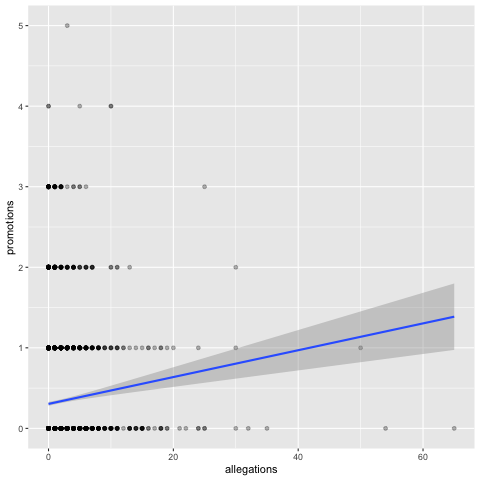

In [6]:
%%R -i summary_df

library(ggplot2)

ggplot(summary_df, aes(x = allegations, y = promotions)) + geom_point(alpha = 0.3) + geom_smooth(method = 'lm')

## It looks like there's a solid positive correlation here, but it's possible this is reflecting something less nefarious than it appears. For example, I would imagine that officers who have worked at the department for longer periods of time are both more likely to have been involved in _something_ that landed them in hot water with internal affairs and more likely to have been promoted.

In [7]:
%%R -i summary_df

TukeyHSD(aov(promotions ~ factor(allegations), data = summary_df))

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = promotions ~ factor(allegations), data = summary_df)

$`factor(allegations)`
               diff          lwr       upr     p adj
1-0    2.899744e-01  0.159019852 0.4209290 0.0000000
2-0    2.061266e-01  0.052462572 0.3597906 0.0001983
3-0    2.292596e-01  0.024871191 0.4336480 0.0089568
4-0    2.257406e-01 -0.003719428 0.4552005 0.0613555
5-0    3.013156e-01  0.026807679 0.5758235 0.0128871
6-0    1.867795e-01 -0.097803672 0.4713627 0.8122525
7-0    3.096566e-01 -0.086465508 0.7057788 0.4421019
8-0    1.461951e-01 -0.356863523 0.6492537 0.9999999
9-0    1.045284e-01 -0.604746943 0.8138038 1.0000000
10-0   5.711951e-01  0.020678348 1.1217118 0.0304109
11-0   3.426237e-01 -0.314370975 0.9996183 0.9857860
12-0   4.378618e-01 -0.977444930 1.8531685 0.9999994
13-0   1.461951e-01 -0.721603921 1.0139941 1.0000000
14-0  -6.213824e-02 -1.063676411 0.9393999 1.0000000
15-0  -1.176938e-01 -0.936070605 

## Interestingly, the difference is only significant when an officer gets their first 1-3 allegations -- you can open the full output in a text editor, it's a sea of 1.0's other than the first few. I'm not sure how to interpret this! What about going from 0 to 1 allegations against an officer makes them more likely to be promoted? Am I misreading this?

In [15]:
%%R -i summary_df

summary(lm(promotions ~ allegations, data = summary_df))


Call:
lm(formula = promotions ~ allegations, data = summary_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3865 -0.3204 -0.3038 -0.3038  4.6463 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.303759   0.012524  24.255  < 2e-16 ***
allegations 0.016658   0.003307   5.037 4.99e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6584 on 3277 degrees of freedom
Multiple R-squared:  0.007682,	Adjusted R-squared:  0.007379 
F-statistic: 25.37 on 1 and 3277 DF,  p-value: 4.994e-07



## This is (part of) it! I was able to add the above cell after Wednesday's class and see the R squared. It looks like what this means is the number of allegations is likely involved, but only explains a small amount of the variance. So we're back to where I was before: total allegations of misconduct and allegations of misconduct sustained by the Department are not good predictors of how many promotions a BPD officer got in the decade we're looking at. It's good to have some stats to back this up, though! I was honestly going by vibes before and saying "eh, those numbers are closer together than I expected."

## I think this data needs to be broken down in a more granular way to be more useful. For example, the specific allegations (sleeping on the job or excessive force, for example) and the type of allegations (citizen complaints submitted by people outside the Department or internal investigations initiated by the BPD) are included in the raw data I used to make the csv I imported here. There is something to go off though, statistical evidence that a police department's promotion process does not weed out officers who commit misconduct, even many times, is noteworthy. 